# 📰 Fake News Detection System
## Machine Learning & Deep Learning Approach

---

### Project Overview
This notebook implements a comprehensive **Fake News Detection System** using both traditional machine learning (Logistic Regression with TF-IDF) and deep learning (BERT) approaches.

### Key Features:
- **Dual-model architecture**: Compare traditional ML vs. deep learning
- **Optimized BERT training**: Efficient training on partial data with advanced techniques
- **Interactive prediction**: Test both models on custom news articles

### Dataset
- **Source**: Kaggle Fake and Real News Dataset
- **Size**: ~45,000 articles
- **Classes**: REAL (1) and FAKE (0)

---

## 1. Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")

PyTorch: 2.9.1+cu126 | CUDA: True


---

## Data Loading & Exploration

Loading the Kaggle Fake and Real News Dataset containing ~45,000 articles labeled as real or fake.

In [2]:
real_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

real_news['label'] = 1
fake_news['label'] = 0

df = pd.concat([real_news, fake_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Check for missing values
print("Missing values:")
print(df.isnull().sum())


print(f"Dataset: {len(df)} articles | Real: {df['label'].sum()} | Fake: {len(df) - df['label'].sum()}")
df.head(10)

Missing values:
title        0
text         0
subject      0
date         0
label        0
full_text    0
dtype: int64
Dataset: 44898 articles | Real: 21417 | Fake: 23481


,title,text,subject,date,label,full_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,Failed GOP Candidates Remembered In Hilarious...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,California AG pledges to defend birth control ...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,AZ RANCHERS Living On US-Mexico Border Destroy...
5,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",1,"As private lawyer, Trump high court pick was f..."
6,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",1,Yemeni Salafist imam killed in Aden: sources A...
7,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",1,FBI says witnesses in U.S. probe into Malaysia...
8,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",0,An Easy To Read Chart Shows How Bernie Sanders...
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",0,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...


### Data Visualization
Visualizing class distribution and text length patterns.

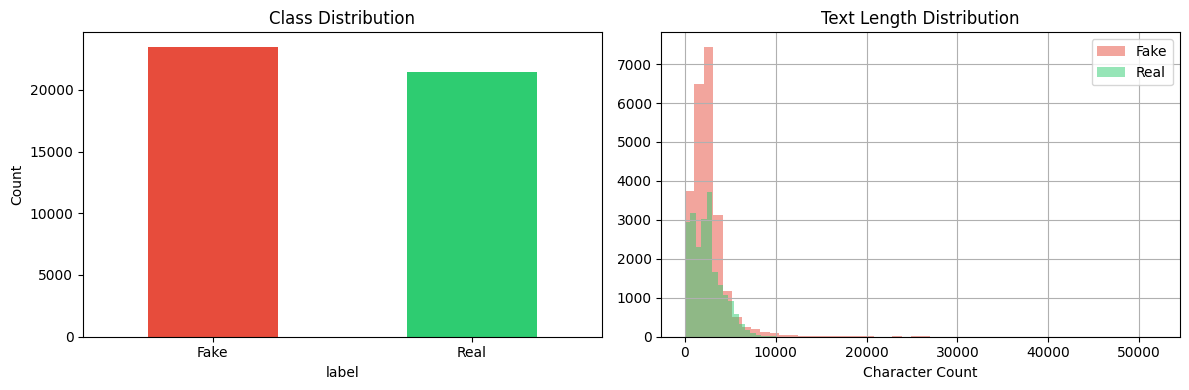

In [3]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
colors = ['#e74c3c', '#2ecc71']
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Class Distribution')
axes[0].set_xticklabels(['Fake', 'Real'], rotation=0)
axes[0].set_ylabel('Count')

# Text length distribution
df['text_length'] = df['full_text'].apply(len)
df[df['label']==0]['text_length'].hist(bins=50, alpha=0.5, label='Fake', ax=axes[1], color='#e74c3c')
df[df['label']==1]['text_length'].hist(bins=50, alpha=0.5, label='Real', ax=axes[1], color='#2ecc71')
axes[1].set_title('Text Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].legend()

plt.tight_layout()
plt.show()

In [4]:
# Train-Test Split (80-20)
X = df['full_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")

Training Set: 35918 samples
Testing Set: 8980 samples


---

## Data Preprocessing & Feature Engineering

### Train-Test Split
Using stratified 80-20 split to maintain class distribution.

In [5]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocess text for TF-IDF vectorization:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove HTML tags
    4. Remove special characters
    5. Remove stopwords
    6. Apply lemmatization
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

In [6]:
# Apply preprocessing
print("Preprocessing training data...")
X_train_processed = X_train.apply(preprocess_text)
print("Preprocessing testing data...")
X_test_processed = X_test.apply(preprocess_text)
print("Preprocessing complete!")

Preprocessing training data...


KeyboardInterrupt: 

### Text Preprocessing for TF-IDF
Cleaning text: lowercase, remove URLs, HTML, special characters, stopwords, and apply lemmatization.

In [ ]:

tfidf_basic = TfidfVectorizer(
    max_features=10000,        # Started with 100 features (terms) to limit complexity | increased to 1000 | increased to 10000 | increased to 100000
    ngram_range=(1, 2),      # Started with unigrams only (single words) | changed to unigrams + bigrams
    min_df=100,              # Started with 100 (consider terms that appear in at least 100 documents) | changed to 50
    max_df=0.9               # Started with 0.1 (remove terms that appear in more than 10% of documents) | changed to 50% | changed to 90%
)

#first test accuracy - 80.82%
#second test accuracy - 94.34% \ just increasing the fitures by 10 times
#third test accuracy - 96.85% 
# fourth test accuracy - 98.14 % changing to unigram-bigram
#fifth - 98.00% lost accuracy
#sixth - 98.92% 
#seventh - 99.10%

X_train_basic = tfidf_basic.fit_transform(X_train_processed)
X_test_basic = tfidf_basic.transform(X_test_processed)

print(f"Features: {X_train_basic.shape[1]}")

Features: 9897


---

## Traditional ML: Logistic Regression with TF-IDF

### TF-IDF Vectorization
Transforming text into numerical features using Term Frequency-Inverse Document Frequency with unigrams + bigrams.

In [ ]:
# Initialize Logistic Regression with 100 iterations for convergence and fixed random seed for reproducibility
lr_basic = LogisticRegression(max_iter=100, random_state=42 ) 
lr_basic.fit(X_train_basic, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

### Model Training & Evaluation
Training Logistic Regression - fast, interpretable, works well with high-dimensional sparse data.

In [ ]:
y_pred_lr = lr_basic.predict(X_test_basic)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)



print("=" * 50)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 50)
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")

LOGISTIC REGRESSION RESULTS
Accuracy:  0.9910 (99.10%)
Precision: 0.9879
Recall:    0.9932
F1-Score:  0.9906


### Confusion Matrix
Visualizing model predictions vs actual labels.

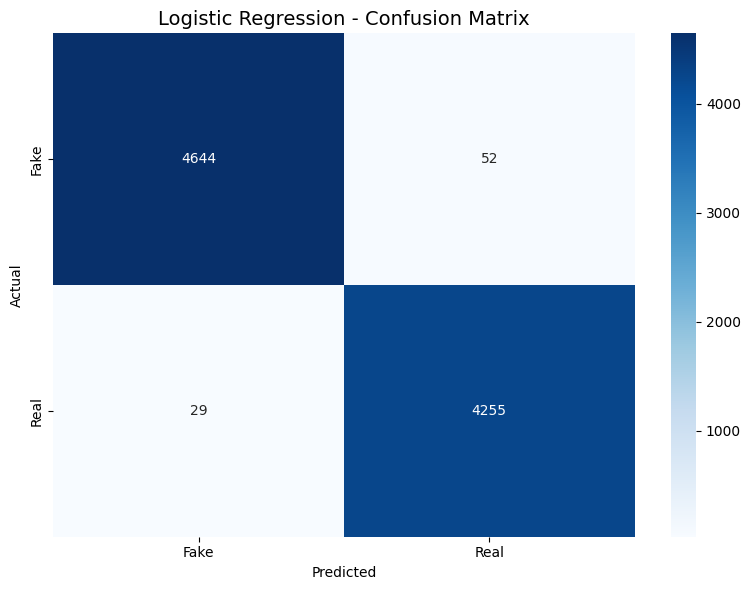

In [ ]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [ ]:
def minimal_preprocess_bert(text):
    """
    Minimal preprocessing for BERT model.
    Preserves natural language structure for contextual understanding.
    
    Steps:
    1. Remove URLs
    2. Remove HTML tags
    3. Convert to lowercase (for uncased model)
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Convert to lowercase (for bert-base-uncased)
    text = text.lower()
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

---

## Deep Learning: BERT Model

### Minimal Preprocessing for BERT
BERT needs less preprocessing - it understands context. Only removing URLs and HTML tags.

In [ ]:
print("Applying minimal preprocessing for BERT...")
X_train_bert = X_train.apply(minimal_preprocess_bert)
X_test_bert = X_test.apply(minimal_preprocess_bert)

print("Preprocessing complete!")

Applying minimal preprocessing for BERT...
Preprocessing complete!


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length (BERT limit is 512)
MAX_LENGTH = 256  # Using 256 for efficiency

print(f"Tokenizer loaded: bert-base-uncased")
print(f"Max sequence length: {MAX_LENGTH}")

Using device: cuda
Tokenizer loaded: bert-base-uncased
Max sequence length: 256


### BERT Tokenizer Setup
Loading the bert-base-uncased tokenizer with WordPiece tokenization.

In [ ]:
# Custom Dataset class for BERT
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = NewsDataset(X_train_bert, y_train, tokenizer, MAX_LENGTH)
test_dataset = NewsDataset(X_test_bert, y_test, tokenizer, MAX_LENGTH)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 35918
Testing dataset size: 8980


### Custom Dataset Class
PyTorch Dataset for handling tokenization, attention masks, and labels.

In [ ]:
# we are going to use a subset of the data for faster training as it will take forever to train on full data
USE_SUBSET = True
SUBSET_SIZE = 5000  # Number of samples for quick training

if USE_SUBSET:
    print(f"Using subset of {SUBSET_SIZE} samples for faster training...")
    
    # Sample indices
    train_indices = np.random.choice(len(train_dataset), min(SUBSET_SIZE, len(train_dataset)), replace=False)
    test_indices = np.random.choice(len(test_dataset), min(SUBSET_SIZE // 4, len(test_dataset)), replace=False)
    
    # Create subset datasets
    X_train_subset = X_train_bert.iloc[train_indices]
    y_train_subset = y_train.iloc[train_indices]
    X_test_subset = X_test_bert.iloc[test_indices]
    y_test_subset = y_test.iloc[test_indices]
    
    train_dataset = NewsDataset(X_train_subset, y_train_subset, tokenizer, MAX_LENGTH)
    test_dataset = NewsDataset(X_test_subset, y_test_subset, tokenizer, MAX_LENGTH)
    
    print(f"Subset training size: {len(train_dataset)}")
    print(f"Subset testing size: {len(test_dataset)}")
else:
    y_test_subset = y_test  # Use full test set

# Create data loaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

Using subset of 5000 samples for faster training...
Subset training size: 5000
Subset testing size: 1250

Batch size: 16
Training batches: 313
Testing batches: 79


### Subset Training
Using 5,000 samples for faster training while maintaining good performance.

In [ ]:
# Load pre-trained BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification (Fake/Real)
    output_attentions=False,
    output_hidden_states=False
)

bert_model.to(device)
print(f"BERT model loaded and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded and moved to cuda
Model parameters: 109,483,778


### Load Pre-trained BERT Model
Using bert-base-uncased with 110M parameters for sequence classification.

In [ ]:
# Training hyperparameters (optimized for partial data)
EPOCHS = 3  # More epochs for better convergence on smaller dataset
LEARNING_RATE = 3e-5  # Slightly higher LR for faster convergence
WEIGHT_DECAY = 0.01  # L2 regularization to prevent overfitting

# Optimizer with weight decay for regularization
optimizer = AdamW(
    bert_model.parameters(), 
    lr=LEARNING_RATE, 
    eps=1e-8,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler with warmup (10% of steps)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% warmup for stable training

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("=" * 60)
print("OPTIMIZED BERT TRAINING CONFIGURATION")
print("=" * 60)
print(f"Training epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps} ({warmup_steps/total_steps*100:.1f}%)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Effective samples: {len(train_dataset)}")

OPTIMIZED BERT TRAINING CONFIGURATION
Training epochs: 3
Learning rate: 3e-05
Weight decay: 0.01
Total training steps: 939
Warmup steps: 93 (9.9%)
Batch size: 16
Effective samples: 5000


In [ ]:
# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(actual_labels, predictions)
    
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, predictions, actual_labels

### Training & Evaluation Functions
Functions with gradient clipping, learning rate warmup, and weight decay.

In [ ]:
# TRAIN BERT MODEL (OPTIMIZED ON PARTIAL DATA)
import time

print("=" * 70)
print("STARTING OPTIMIZED BERT TRAINING")
print("=" * 70)

train_losses = []
train_accuracies = []
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")
    
    train_loss, train_acc = train_epoch(
        bert_model, train_loader, optimizer, scheduler, device
    )
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Training Loss: {train_loss:.4f}")
    print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Epoch Time: {epoch_time:.2f} seconds")
    
    # Clear GPU cache after each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_time = time.time() - start_time
print("\n" + "=" * 70)
print("BERT TRAINING COMPLETE!")
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print("=" * 70)

STARTING OPTIMIZED BERT TRAINING

EPOCH 1/3


Training: 100%|██████████| 313/313 [03:23<00:00,  1.54it/s, loss=0.000636]



Epoch 1 Results:
  Training Loss: 0.1034
  Training Accuracy: 0.9580 (95.80%)
  Epoch Time: 203.50 seconds

EPOCH 2/3


Training: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s, loss=0.000193]



Epoch 2 Results:
  Training Loss: 0.0037
  Training Accuracy: 0.9992 (99.92%)
  Epoch Time: 138.55 seconds

EPOCH 3/3


Training: 100%|██████████| 313/313 [02:18<00:00,  2.27it/s, loss=0.000133]


Epoch 3 Results:
  Training Loss: 0.0011
  Training Accuracy: 0.9994 (99.94%)
  Epoch Time: 138.03 seconds

BERT TRAINING COMPLETE!
Total Training Time: 480.16 seconds (8.00 minutes)


### Model Training
Fine-tuning BERT on our fake news detection task.

In [ ]:
# Evaluate on test set
print("Evaluating BERT model on test set...")
test_loss, y_pred_bert, y_true_bert = evaluate(bert_model, test_loader, device)

# Calculate metrics
bert_accuracy = accuracy_score(y_true_bert, y_pred_bert)
bert_precision = precision_score(y_true_bert, y_pred_bert)
bert_recall = recall_score(y_true_bert, y_pred_bert)
bert_f1 = f1_score(y_true_bert, y_pred_bert)

print("\n" + "=" * 50)
print("BERT MODEL RESULTS")
print("=" * 50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy:  {bert_accuracy:.4f} ({bert_accuracy*100:.2f}%)")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall:    {bert_recall:.4f}")
print(f"F1-Score:  {bert_f1:.4f}")


Evaluating BERT model on test set...


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]


BERT MODEL RESULTS
Test Loss: 0.0046
Accuracy:  0.9992 (99.92%)
Precision: 0.9984
Recall:    1.0000
F1-Score:  0.9992

--- Classification Report ---
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       625
        Real       1.00      1.00      1.00       625

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



### Model Evaluation & Confusion Matrix
Evaluating BERT on the test set.

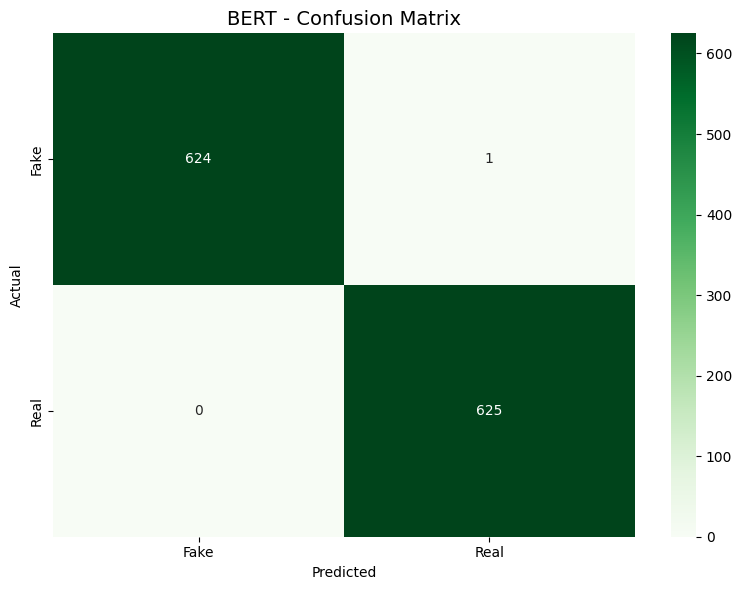

In [ ]:
# Confusion Matrix for BERT
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title('BERT - Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [ ]:
# TEST BOTH MODELS ON YOUR OWN NEWS ARTICLE

def predict_news(text):
    """
    Predict whether a news article is Real or Fake using both models.
    
    Args:
        text: The news article text (can include title + body)
    
    Returns:
        Predictions from both Logistic Regression and BERT models
    """
    print("=" * 60)
    print("FAKE NEWS DETECTION - PREDICTION")
    print("=" * 60)
    print(f"\nInput text (first 200 chars): {text[:200]}...")
    
    # ---- Logistic Regression Prediction ----
    # Apply preprocessing (using preprocess_text function)
    processed_text_lr = preprocess_text(text)
    
    # Transform using TF-IDF vectorizer
    text_tfidf = tfidf_basic.transform([processed_text_lr])
    
    # Predict
    lr_prediction = lr_basic.predict(text_tfidf)[0]
    lr_probability = lr_basic.predict_proba(text_tfidf)[0]
    
    print("\n" + "-" * 40)
    print("LOGISTIC REGRESSION PREDICTION:")
    print("-" * 40)
    print(f"Prediction: {'REAL ✓' if lr_prediction == 1 else 'FAKE ✗'}")
    print(f"Confidence: Fake={lr_probability[0]*100:.2f}%, Real={lr_probability[1]*100:.2f}%")
    
    # ---- BERT Prediction ----
    # Apply minimal preprocessing
    processed_text_bert = minimal_preprocess_bert(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        processed_text_bert,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device and predict
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        bert_prediction = torch.argmax(logits, dim=1).item()
        bert_probs = probabilities[0].cpu().numpy()
    
    print("\n" + "-" * 40)
    print("BERT PREDICTION:")
    print("-" * 40)
    print(f"Prediction: {'REAL ✓' if bert_prediction == 1 else 'FAKE ✗'}")
    print(f"Confidence: Fake={bert_probs[0]*100:.2f}%, Real={bert_probs[1]*100:.2f}%")
    
    # ---- Summary ----
    print("\n" + "=" * 60)
    print("SUMMARY:")
    print("=" * 60)
    if lr_prediction == bert_prediction:
        verdict = "REAL" if lr_prediction == 1 else "FAKE"
        print(f"Both models agree: This article is likely {verdict}")
    else:
        print("Models disagree! Consider manual review.")
        print(f"  - Logistic Regression says: {'REAL' if lr_prediction == 1 else 'FAKE'}")
        print(f"  - BERT says: {'REAL' if bert_prediction == 1 else 'FAKE'}")
    
    return {
        'logistic_regression': {'prediction': lr_prediction, 'probabilities': lr_probability},
        'bert': {'prediction': bert_prediction, 'probabilities': bert_probs}
    }


---

## Interactive Prediction System

Testing both models on custom news articles with confidence scores.

In [ ]:
# Test with a REAL news article from CNN
real_news_article = """
Groundbreaking Discovery: Ancient Time Travel Portal Unveiled in Antarctica
In a groundbreaking discovery that has sent shockwaves through the scientific community, an international team of researchers has uncovered what they believe to be an ancient time travel portal hidden deep beneath the ice of Antarctica. This astonishing find, located in a previously unexplored cavern system beneath the Antarctic ice shelf, is poised to challenge everything humanity knows about the nature of time and space.

The discovery was made during a routine ice core drilling expedition led by a team from the University of Oxford, in collaboration with researchers from NASA and the European Space Agency (ESA). According to Dr. Eleanor Thompson, the lead scientist on the expedition, the team stumbled upon a series of mysterious metallic structures buried several hundred meters beneath the surface. The structures appeared to be ancient, yet incredibly advanced, suggesting they were created by a civilization far more technologically sophisticated than anything previously known.

"The portal we discovered seems to defy the known laws of physics," Dr. Thompson said in a statement. "It’s an interdimensional gateway that appears to bend the very fabric of time itself. We’ve yet to fully understand how it works, but the possibilities are extraordinary."

The portal, which measures several meters in diameter, is surrounded by intricate symbols and patterns that seem to match no known language. Researchers have speculated that the portal could be of extraterrestrial origin, while others believe it could be the work of a long-lost ancient civilization that mastered time travel thousands of years ago.

Experts are divided on the implications of the find. Some believe that the portal could offer a means of traveling back in time, while others suggest it may allow passage into alternate realities. However, scientists have expressed caution, warning that any attempt to activate the portal could have unpredictable and potentially catastrophic consequences.

"This discovery could change everything," said Professor Richard Hartley, a leading physicist at MIT. "If the portal truly operates as a time travel device, we are faced with profound ethical and existential questions. The implications for our understanding of history, causality, and even the future are limitless. But we must approach this with the utmost care."

The team plans to conduct further tests in the coming months, with the goal of understanding the portal’s mechanisms and determining whether it can be safely accessed. Meanwhile, governments around the world have already begun to monitor the situation closely, with some speculating that the discovery could lead to a new arms race for control of the portal.

"This discovery could be the key to unlocking the future—or unleashing chaos," said one unnamed government official. "The world is watching."

In the meantime, the Antarctic research station has been placed under high security as scientists continue their work. The full details of the discovery, including photographs and data, are expected to be released to the public in the coming weeks.

As the world holds its breath, one question remains: Could time travel be real?

"""

# Run prediction on the real CNN news article
print("Testing with REAL news article from CNN:")
print("-" * 60)
result = predict_news(real_news_article)

Testing with REAL news article from CNN:
------------------------------------------------------------
FAKE NEWS DETECTION - PREDICTION

Input text (first 200 chars): 
Groundbreaking Discovery: Ancient Time Travel Portal Unveiled in Antarctica
In a groundbreaking discovery that has sent shockwaves through the scientific community, an international team of researche...

----------------------------------------
LOGISTIC REGRESSION PREDICTION:
----------------------------------------
Prediction: FAKE ✗
Confidence: Fake=71.70%, Real=28.30%

----------------------------------------
BERT PREDICTION:
----------------------------------------
Prediction: FAKE ✗
Confidence: Fake=98.35%, Real=1.65%

SUMMARY:
Both models agree: This article is likely FAKE


---

## Model Comparison

Comparing Logistic Regression vs BERT across all evaluation metrics.

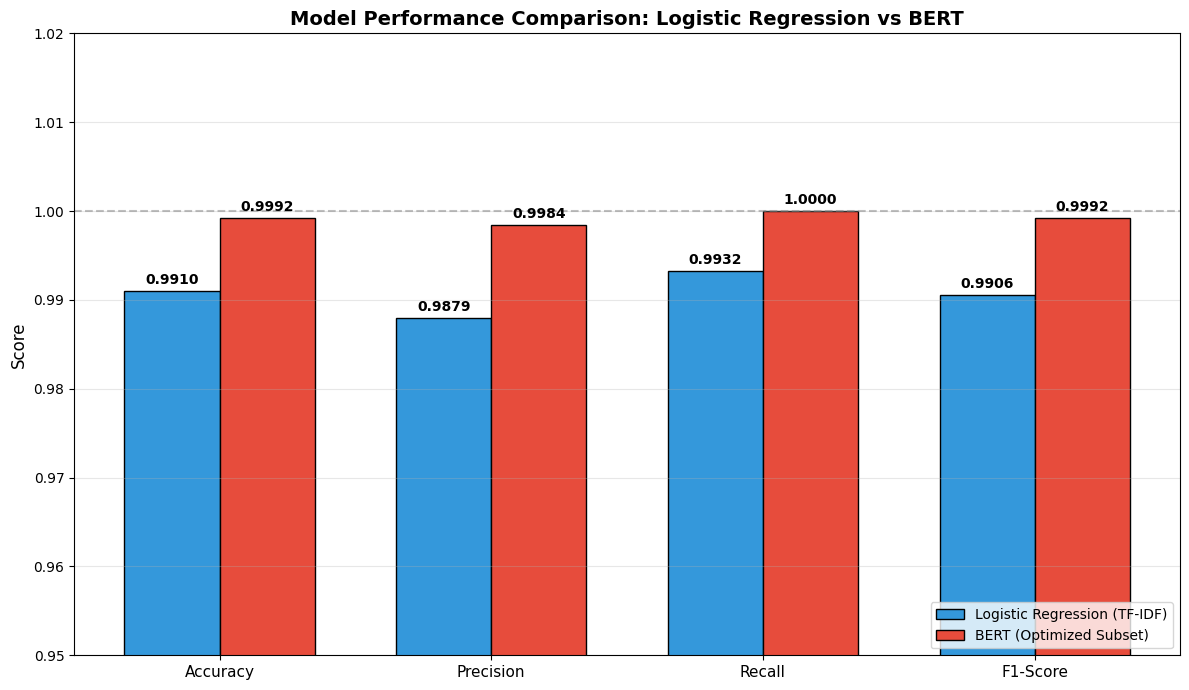


MODEL PERFORMANCE SUMMARY
Metric          Logistic Regression    BERT (Optimized)    
------------------------------------------------------------
Accuracy        99.10%                 99.92%
Precision       98.79%                 99.84%
Recall          99.32%                 100.00%
F1-Score        99.06%                 99.92%


In [ ]:
# MODEL PERFORMANCE COMPARISON VISUALIZATION

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lr_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
bert_scores = [bert_accuracy, bert_precision, bert_recall, bert_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

bars1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression (TF-IDF)', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, bert_scores, width, label='BERT (Optimized Subset)', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: Logistic Regression vs BERT', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim(0.95, 1.02)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary comparison
print("\n" + "=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Metric':<15} {'Logistic Regression':<22} {'BERT (Optimized)':<20}")
print("-" * 60)
for i, metric in enumerate(metrics):
    print(f"{metric:<15} {lr_scores[i]*100:.2f}%{'':<16} {bert_scores[i]*100:.2f}%")